# Data Loading

In [245]:
import os

def get_file_names(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    # Filter out directories, leaving only files
    file_names = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]
    return file_names

folder_path = './marked_data'
file_names = get_file_names(folder_path)
print("File names in the folder:")
for file_name in file_names:
    print(file_name)
#file_names.pop(-1)

File names in the folder:
result_with_parameters_0.csv
result_with_parameters_1.csv
result_with_parameters_2.csv
result_with_parameters_3.csv
result_with_parameters_4.csv
result_with_parameters_5.csv
result_with_parameters_6.csv


In [246]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = list()
for i, file_name in enumerate(file_names):
    temp = pd.read_csv(f'./marked_data/{file_name}')
    temp = temp.drop(["index", ], axis=1)  # "past_OBV", "upper_ST", "lower_ST"
    data_for_analysis = temp
    y, X = temp["result"], temp.drop(["result"], axis=1)
    data.append([y, X])
    
data[2][1]

,close,open,high,low,volume,EMA_prev_diff,EMA_current_diff,prev_RSI,current_RSI,MACD_prev_diff,...,BB_lower,StochRSI_K,StochRSI_D,ST_upper,ST_lower,ATR,aroon_up,aroon_low,OBV,OBV_MA
0,263.53,263.56,265.70,263.53,37,-0.099600,0.019429,45.567945,45.124158,-0.023559,...,262.860918,0.000000,35.462629,272.381666,256.710874,2.737736,48.0,20.0,925.0,976.600000
1,263.49,265.61,265.62,263.49,5,0.019429,0.129444,45.124158,45.116015,-0.131031,...,262.682165,0.000000,35.462629,272.381666,256.710874,2.763887,44.0,16.0,920.0,968.866667
2,265.62,265.62,265.62,263.49,5,0.129444,0.046205,45.116015,45.643605,-0.195523,...,262.873756,63.772455,56.720114,272.381666,256.710874,2.788295,40.0,12.0,925.0,960.733333
3,263.47,265.64,265.64,263.47,17,0.046205,0.154968,45.643605,45.200612,-0.090766,...,262.689891,0.000000,35.462629,272.381666,256.710874,2.813742,36.0,8.0,908.0,951.933333
4,265.54,265.60,265.60,263.41,21,0.154968,0.075701,45.200612,45.712987,-0.158352,...,262.888151,63.888889,56.758925,272.381666,256.710874,2.838826,32.0,4.0,929.0,946.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20842,261.00,260.98,261.00,260.98,11,-0.042712,-0.144299,50.486276,50.584375,0.057391,...,257.808066,71.509972,59.299286,253.131270,265.480734,2.734126,100.0,72.0,-460154.0,-460262.733333
20843,260.99,258.92,260.99,258.88,23,-0.144299,-0.234307,50.584375,50.579555,0.114630,...,257.794072,71.225071,59.204320,253.131270,265.480734,2.759184,96.0,68.0,-460177.0,-460254.800000
20844,258.91,261.02,261.02,258.91,10,-0.234307,-0.137312,50.579555,49.586911,0.143454,...,257.861182,11.965812,39.451233,253.131270,265.480734,2.782572,92.0,64.0,-460187.0,-460247.466667
20845,258.92,258.90,261.01,258.90,9,-0.137312,-0.051150,49.586911,49.591715,0.020528,...,257.752348,12.250712,39.546200,253.131270,265.480734,2.804401,88.0,60.0,-460178.0,-460239.600000


In [247]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# get data
divided_data = list()
for data_train in data:
    divided_data.append(train_test_split(data_train[1], data_train[0], test_size=0.20, random_state = 2020, stratify=data_train[0]))

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)

# Scale Data

In [248]:
import numpy as np
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
for i, data_train in enumerate(divided_data):
    divided_data[i][0] = ss.fit_transform(data_train[0])
    divided_data[i][1] = ss.fit_transform(data_train[1])
    
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

for i, data_train in enumerate(divided_data):
    X_train_list.append(data_train[0])
    X_test_list.append(data_train[1])
    y_train_list.append(data_train[2])
    y_test_list.append(data_train[3])

X_train_scaled = np.concatenate(X_train_list, axis=0)
X_test_scaled = np.concatenate(X_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

X_train_scaled
# X_train_scaled = ss.fit_transform(X_train)
# X_test_scaled = ss.transform(X_test)
# y_train = np.array(y_train)

array([[ 0.36309476,  0.34671353,  0.3246425 , ...,  0.80935788,
         0.80580854,  0.80881391],
       [-0.91419092, -0.92933454, -0.94974044, ...,  0.80935788,
        -2.69732923, -2.7104513 ],
       [-0.72241715, -0.74704196, -0.75479234, ...,  0.09376889,
        -2.61840689, -2.64737112],
       ...,
       [ 0.00966751,  0.07337922,  0.00593146, ...,  1.52365301,
         1.68223561,  1.80561581],
       [-0.91923898, -0.9067608 , -0.97112339, ..., -0.7345723 ,
        -1.21182891, -1.22440169],
       [ 0.0802644 ,  0.07337922,  0.01341847, ..., -0.85342626,
         0.04735263,  0.04662969]])

# Over Sampling

In [226]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()
#smote = SMOTE()

# Fit SMOTE to the training data
X_train_scaled, y_train = adasyn.fit_resample(X_train_scaled, y_train)
X_train_scaled

array([[ 0.62708071,  0.70674448,  0.66893331, ...,  0.21449596,
         0.38493435,  0.38508512],
       [ 0.56186488,  0.56939925,  0.53152222, ...,  1.52789133,
         0.48787249,  0.49300678],
       [-0.12652441, -0.14082016, -0.16276539, ...,  1.28909217,
        -1.43700722, -1.42779322],
       ...,
       [-0.64336275, -0.62885709, -0.66398359, ...,  1.25448523,
        -0.75720152, -0.77478978],
       [-0.6323245 , -0.67203493, -0.66981425, ...,  0.7486046 ,
        -0.68406828, -0.67935978],
       [-0.64345032, -0.70413997, -0.70525398, ...,  0.58540076,
        -1.203545  , -1.23532754]])

# Undersempling

In [227]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler()

# Fit undersampler to the training data
X_train_scaled, y_train = undersampler.fit_resample(X_train_scaled, y_train)
X_train_scaled

array([[ 0.56186488,  0.56939925,  0.53152222, ...,  1.52789133,
         0.48787249,  0.49300678],
       [-0.12652441, -0.14082016, -0.16276539, ...,  1.28909217,
        -1.43700722, -1.42779322],
       [ 0.74120841,  0.33446662,  0.70871021, ..., -0.62130109,
         0.38447919,  0.38438185],
       ...,
       [ 0.62668173,  0.62171502,  0.57813486, ..., -0.39188759,
         0.91603675,  0.91587978],
       [ 0.3758022 ,  0.38478864,  0.35094068, ...,  1.46165363,
         0.78608053,  0.82560154],
       [ 0.60062757,  0.59936278,  0.55505786, ..., -0.31367789,
         0.04678043,  0.04658299]])

# Learning

In [249]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))
display(rfc.score(X_test_scaled, y_test))

1.0

0.9657748611812216

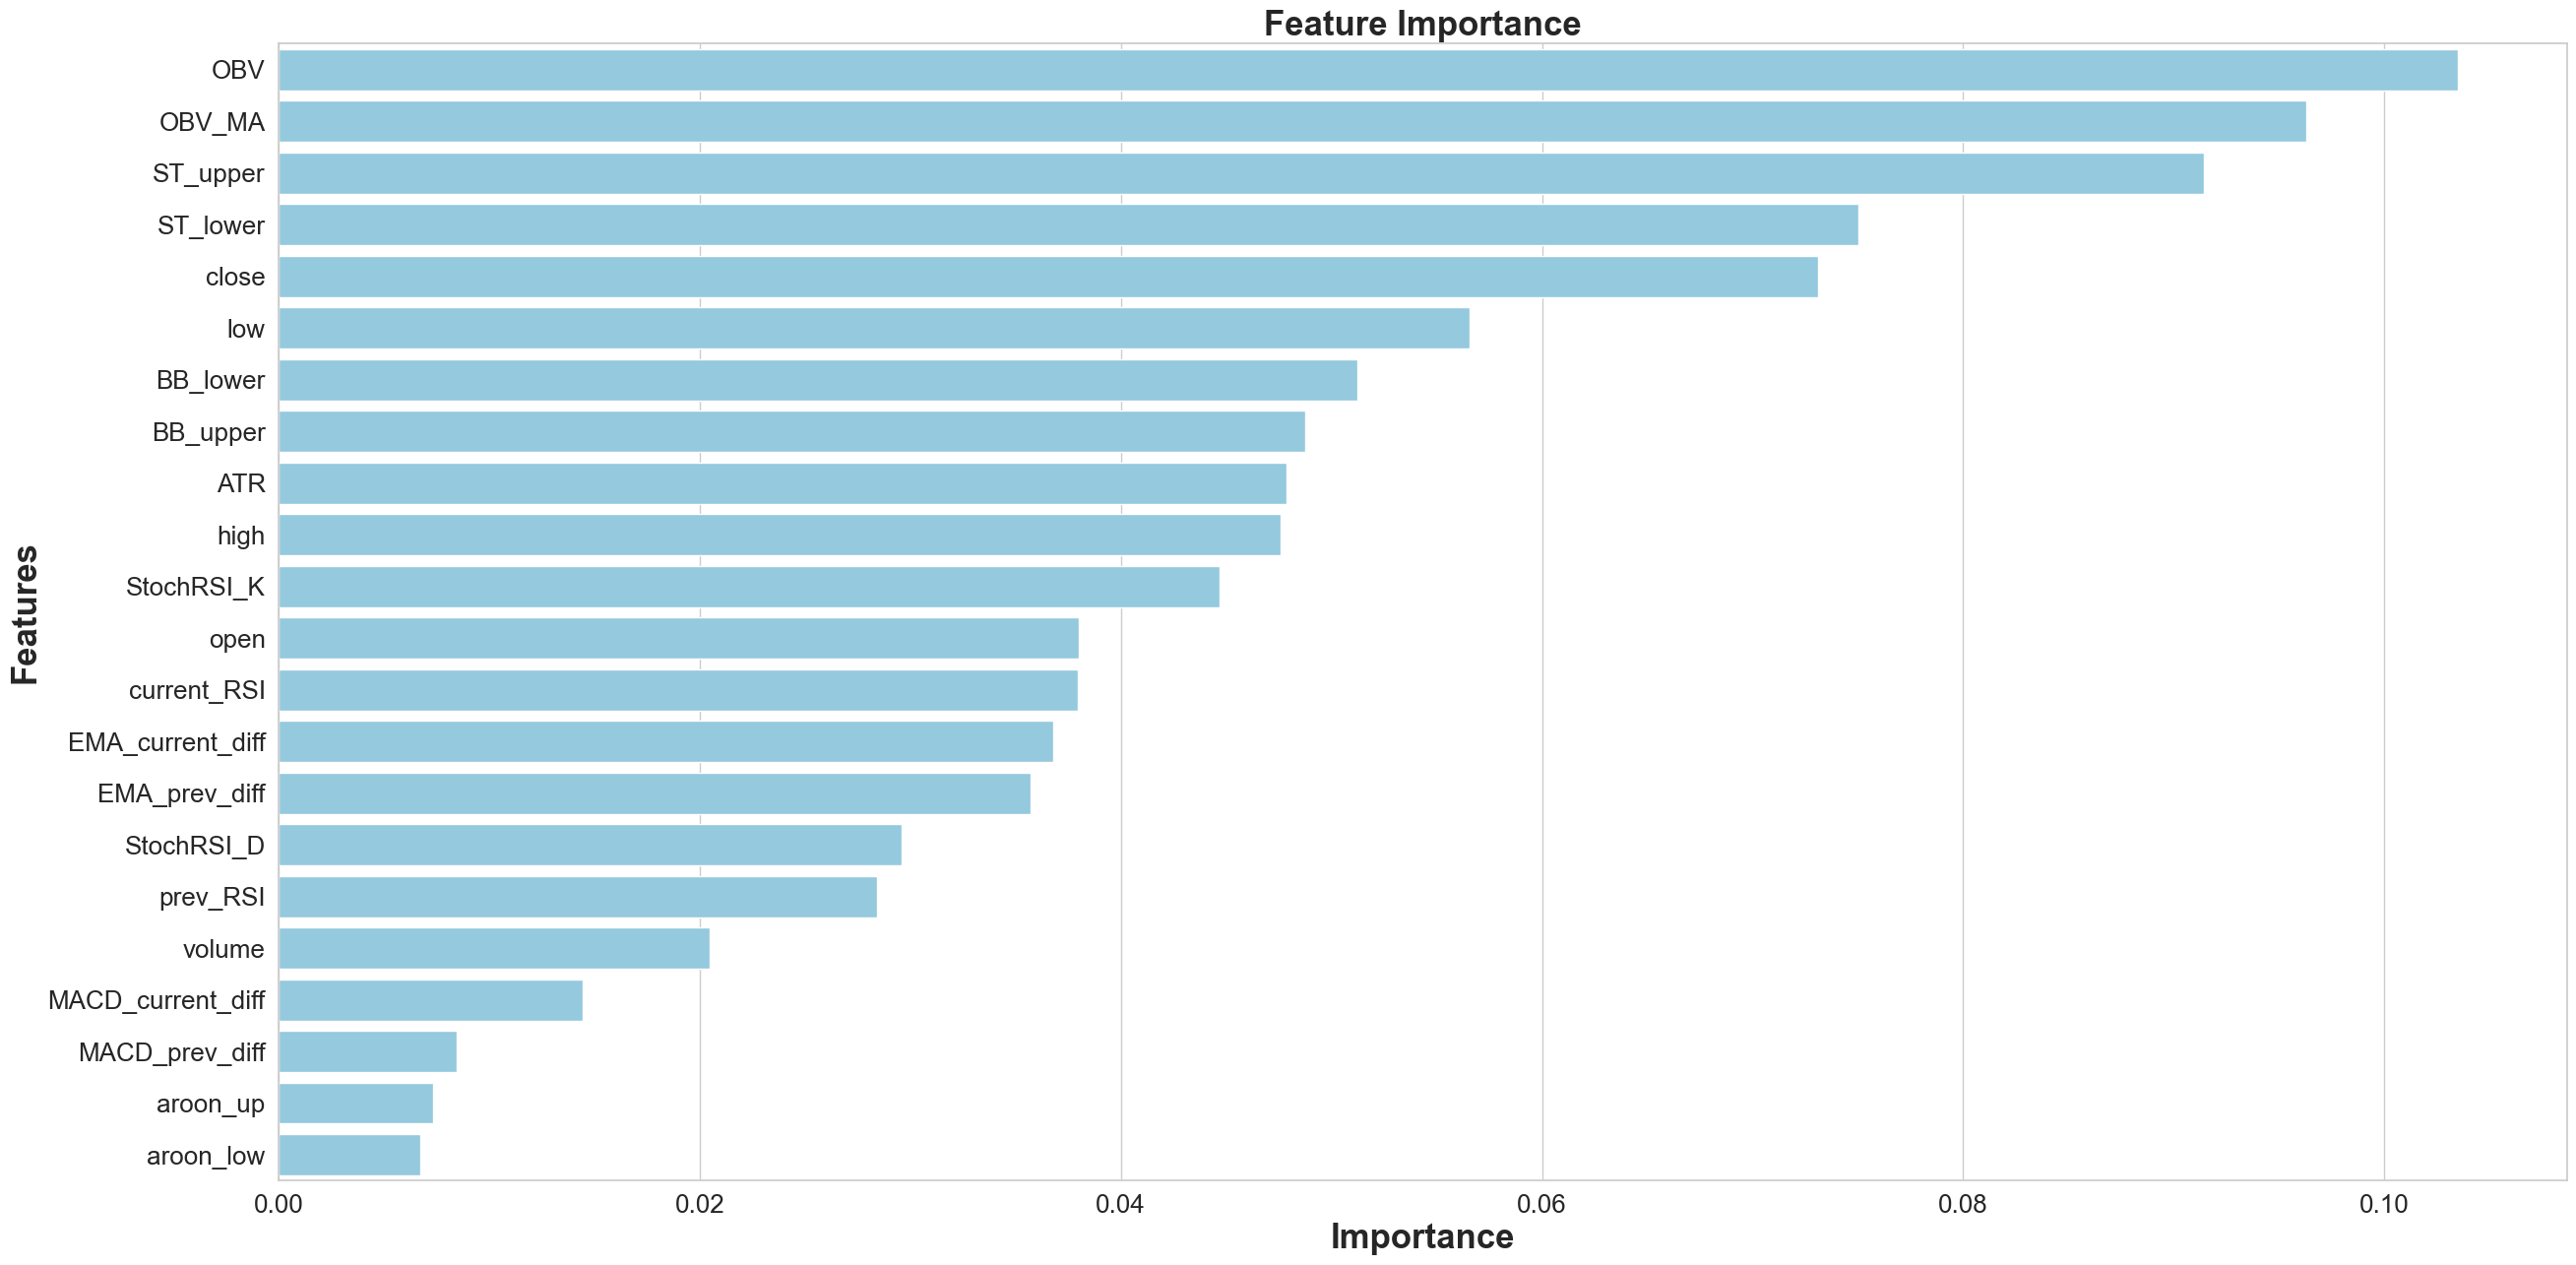

None

,Features,Gini-Importance
0,OBV,0.103500
1,OBV_MA,0.096289
2,ST_upper,0.091428
3,ST_lower,0.075026
4,close,0.073093
5,low,0.056573
6,BB_lower,0.051228
7,BB_upper,0.048737
8,ATR,0.047866
9,high,0.047611


In [250]:
from matplotlib import pyplot as plt
import seaborn as sns

feats = {}
for feature, importance in zip(data_for_analysis.drop("result", axis=1).columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

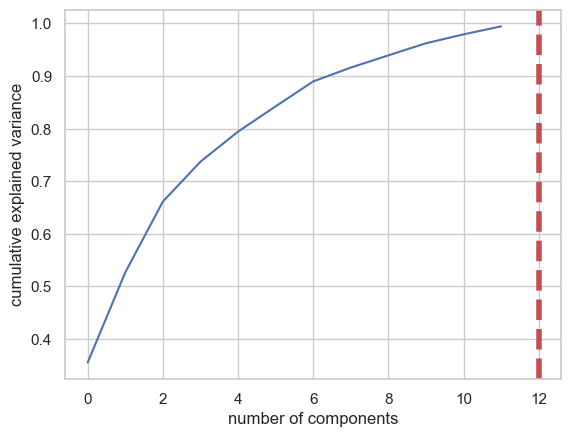

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.355494,0.355494
1,0.526851,0.171357
2,0.661324,0.134473
3,0.737143,0.075819
4,0.794289,0.057146
5,0.842347,0.048057
6,0.889756,0.047409
7,0.916057,0.026302
8,0.939291,0.023234
9,0.962307,0.023015


In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca_test = PCA(n_components=12)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=12, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(12))

In [212]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100,
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [232]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameters
param_grid = {
    'n_estimators': 600,
    'min_samples_split': 23,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 15,
    'bootstrap': False
}

# Instantiate Random Forest classifier with specified hyperparameters
rf_classifier = RandomForestClassifier(**param_grid)

# Train the model (assuming X_train and y_train are your training data)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_leaf=2,
                       min_samples_split=23, n_estimators=600)

In [252]:
"""
just in case
{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}
"""

from sklearn.metrics import confusion_matrix, precision_score

# y_pred_probs = rfc.predict_proba(X_test_scaled)[:, 1]
# 
# new_threshold = 0.5  # Example: setting a higher threshold
# 
# # Adjust the predicted labels based on the new threshold
# y_pred = (y_pred_probs >= new_threshold).astype(int)
y_pred = rfc.predict(X_test_scaled)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))
display('Baseline Random Forest precision score', precision_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,19404,406
actual 1,611,9294


'Baseline Random Forest recall score'

0.938313982836951

'Baseline Random Forest precision score'

0.9581443298969072

In [132]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = rfc.predict(X_test_scaled)

# Assuming y_test, y_pred are both three-dimensional arrays or lists
# You need to calculate confusion matrices and scores for each class

conf_matrices = []
precision_scores = []
recall_scores = []

for class_label in [-1, 0, 1]:
    y_test_class = (y_test == class_label).astype(int)
    y_pred_class = (y_pred == class_label).astype(int)
    
    conf_matrix_class = confusion_matrix(y_test_class, y_pred_class)
    conf_matrices.append(conf_matrix_class)
    
    precision_score_class = precision_score(y_test_class, y_pred_class, average='binary')
    precision_scores.append(precision_score_class)
    
    recall_score_class = recall_score(y_test_class, y_pred_class, average='binary')
    recall_scores.append(recall_score_class)

# Display the confusion matrices
for idx, class_label in enumerate([-1, 0, 1]):
    print(f'Confusion matrix for class {class_label}:')
    display(pd.DataFrame(conf_matrices[idx], index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1']))

# Display precision scores
for idx, class_label in enumerate([-1, 0, 1]):
    print(f'Precision score for class {class_label}: {precision_scores[idx]}')

# Display recall scores
for idx, class_label in enumerate([-1, 0, 1]):
    print(f'Recall score for class {class_label}: {recall_scores[idx]}')

Confusion matrix for class -1:


,predicted 0,predicted 1
actual 0,25176,3586
actual 1,98,855


Confusion matrix for class 0:


,predicted 0,predicted 1
actual 0,1648,262
actual 1,12513,15292


Confusion matrix for class 1:


,predicted 0,predicted 1
actual 0,19714,9044
actual 1,281,676


Precision score for class -1: 0.1925242062598514
Precision score for class 0: 0.9831554584029831
Precision score for class 1: 0.06954732510288066
Recall score for class -1: 0.8971668415529905
Recall score for class 0: 0.5499730264340946
Recall score for class 1: 0.7063740856844305


In [253]:
from joblib import dump

model_filename = 'random_forest_model.joblib'
dump(rfc, model_filename)

['random_forest_model.joblib']

# Gradient Boosting model

In [232]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
import xgboost as xgb

# Create a Gradient Boosting Classifier instance
gbm = xgb.XGBClassifier()

# Fit the model to the training data
gbm.fit(X_train_scaled, y_train)

# Evaluate the model on the training and test data
train_score = gbm.score(X_train_scaled, y_train)
test_score = gbm.score(X_test_scaled, y_test)

print("Training Accuracy:", train_score)
print("Test Accuracy:", test_score)

Training Accuracy: 0.9594722650562969
Test Accuracy: 0.472959784620562


In [233]:
# Calculate recall score on the test data
y_pred_test = gbm.predict(X_test_scaled)
recall = recall_score(y_test, y_pred_test)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_baseline)
print("Test Recall Score:", recall)
display('Test precision score', precision_score(y_test, y_pred_test))

,predicted 0,predicted 1
actual 0,13442,15581
actual 1,80,612


Test Recall Score: 0.884393063583815


'Test precision score'

0.03779410856542951

In [196]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = gbm.predict(X_test_scaled)

# Assuming y_test, y_pred are both three-dimensional arrays or lists
# You need to calculate confusion matrices and scores for each class

conf_matrices = []
precision_scores = []
recall_scores = []

for class_label in [0, 1, 2]:
    y_test_class = (y_test == class_label).astype(int)
    y_pred_class = (y_pred == class_label).astype(int)
    
    conf_matrix_class = confusion_matrix(y_test_class, y_pred_class)
    conf_matrices.append(conf_matrix_class)
    
    precision_score_class = precision_score(y_test_class, y_pred_class, average='binary')
    precision_scores.append(precision_score_class)
    
    recall_score_class = recall_score(y_test_class, y_pred_class, average='binary')
    recall_scores.append(recall_score_class)

# Display the confusion matrices
for idx, class_label in enumerate([0, 1, 2]):
    print(f'Confusion matrix for class {class_label}:')
    display(pd.DataFrame(conf_matrices[idx], index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1']))

# Display precision scores
for idx, class_label in enumerate([0, 1, 2]):
    print(f'Precision score for class {class_label}: {precision_scores[idx]}')

# Display recall scores
for idx, class_label in enumerate([0, 1, 2]):
    print(f'Recall score for class {class_label}: {recall_scores[idx]}')

Confusion matrix for class 0:


,predicted 0,predicted 1
actual 0,8786,19972
actual 1,140,817


Confusion matrix for class 1:


,predicted 0,predicted 1
actual 0,24544,4218
actual 1,56,897


Confusion matrix for class 2:


,predicted 0,predicted 1
actual 0,1833,77
actual 1,24071,3734


Precision score for class 0: 0.03929962961181394
Precision score for class 1: 0.175366568914956
Precision score for class 2: 0.9797953293098924
Recall score for class 0: 0.8537095088819227
Recall score for class 1: 0.9412381951731374
Recall score for class 2: 0.13429239345441468


In [186]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Instantiate the GBM classifier
gbm = GradientBoostingClassifier()

scorer = make_scorer(precision_score)

# Instantiate GridSearchCV with precision as the scoring metric
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring=scorer, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate on test set
test_score = grid_search.score(X_train_scaled, y_test)
print("Test Accuracy:", test_score)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


ValueError: Found input variables with inconsistent numbers of samples: [12243, 88996]

In [192]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate on test set
test_score = grid_search.score(X_test_scaled, y_test)
print("Test Accuracy:", test_score)

y_pred_test = grid_search.predict(X_test_scaled)

display(conf_matrix_baseline)
print("Test Recall Score:", recall_score(y_test, y_pred_test))
display('Test precision score', precision_score(y_test, y_pred_test))

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Test Accuracy: 0.15275634731378876


,predicted 0,predicted 1
actual 0,7439,3671
actual 1,161,972


Test Recall Score: 0.9611650485436893


'Test precision score'

0.15275634731378876